This notebook was modified from the original
notebook, which is part of the ``deepcell-tf`` documentation: https://deepcell.readthedocs.io/.

# Multiplex cell segmentation

    - In this notebook, the segmentation, image processing, and centroid/intensity methods are explored roughly
    - A final, full segmentation can be seen in the 5 Individual Segmentations (DAPI + membrane) notebook
    - Make sure to run each cell once


In [109]:
# Download multiplex data
import deepcell
import numpy as np
from sklearn.model_selection import train_test_split

#load Multiplex Sample Dataset as provided by Van Valen lab
filename = '20200810_tissue_dataset.npz'
test_size = 0.1 # % of data saved as test
seed = 0 # seed for random train-test split

a = np.load(filename)

print(a.files)

a['X'].shape
a['y'].shape

X_train, X_test, y_train, y_test = train_test_split(a['X'], a['y'], test_size=0.10, random_state=26)


['X', 'y']


In [110]:
# select one of the images to display
i = 4
im = X_train[i:(i + 1)]
im.shape

(1, 512, 512, 2)

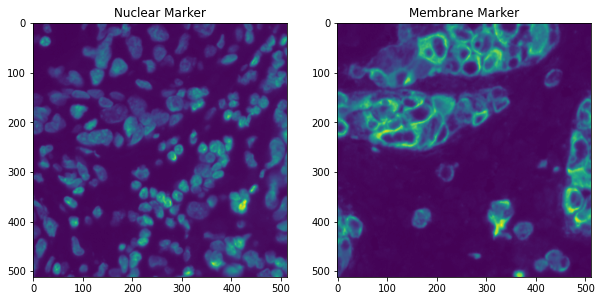

In [111]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(im[0, ..., 0])
ax[0].set_title("Nuclear Marker")
ax[1].set_title("Membrane Marker")
ax[1].imshow(im[0, ..., 1])
plt.show()

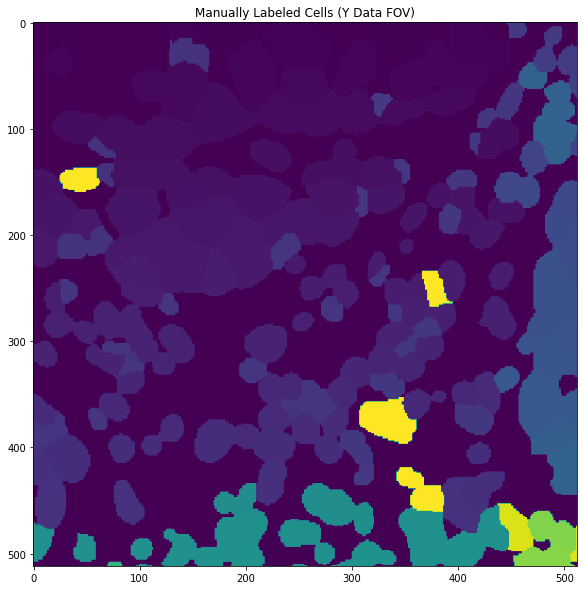

In [117]:
plt.figure(figsize = (10,10))
plt.imshow(y_train[i:(i+1)][0, ..., 0])
plt.title("Manually Labeled Cells (Y Data FOV)")
plt.show()

# New Test Data Preprocessing

- In this section a sample FOV (PDLI + DAPI markers) was preprocessed and segmentated using pretrained weights
- The original .tif was loaded into Qupath and each seperate image was filtered using grayscale option
- The images were then resized to square input, predicted on, and resized back to the original size
- Data Input for training must be a 4D array with [FOV #, Image Row, Image Column, Channel (Nuclear, then Membrane Marker)] 

In [5]:
import matplotlib.image as mpimg
from PIL import Image 
image = mpimg.imread("DAPI1.jpg") #load in data
image2 = mpimg.imread("membrane.jpg")

original_length = image.shape[0] #store original size
original_width = image.shape[1]

image = Image.fromarray(image)
image2 = Image.fromarray(image2)

sqrWidth = np.ceil(np.sqrt(image.size[0]*image.size[1])).astype(int) #resized to square input
im_resize = image.resize((sqrWidth, sqrWidth))
im_resize2 = image2.resize((sqrWidth, sqrWidth))
im_resize = np.array(im_resize)
im_resize2 = np.array(im_resize2)

print(original_width)
print(original_length)

1344
1004


In [6]:
image = im_resize[:,...,0]
image2 = im_resize2[:,...,0]

image = np.expand_dims(image, 0) #create new first dimension (FOV #)
image2 = np.expand_dims(image2, 0) #create new first dimension (FOV #)

image = image[:,...,np.newaxis] #add new axis for marker channel
image = np.repeat(image, 2, axis=3)

image[:,...,1] = image2

image2.shape

(1, 1162, 1162)

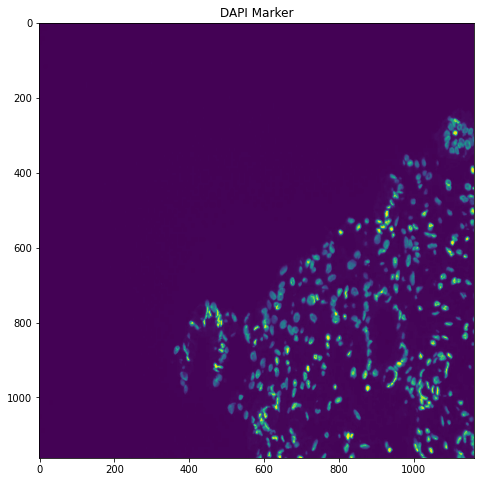

In [123]:
#view markers

plt.figure(figsize = (8,8))
plt.imshow(image[0,...,0])
plt.title("DAPI Marker")
plt.show()

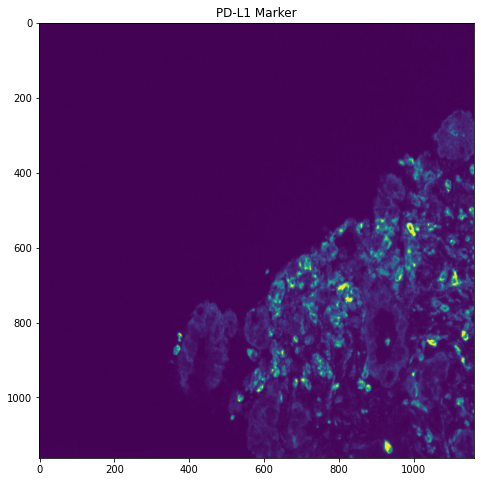

In [124]:
plt.figure(figsize = (8,8))
plt.imshow(image[0,...,1])
plt.title("PD-L1 Marker")
plt.show()

In [125]:
new_test = image
new_test.shape

(1, 1162, 1162, 2)

## Whole Cell Segmentation

### Initialize multiplex model

The application will download pretrained weights for tissue segmentation. For more information about application objects, please see our [documentation](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html).

In [10]:
from deepcell.applications import MultiplexSegmentation
app = MultiplexSegmentation(use_pretrained_weights=True)


313057280/313049476 [==============================] - 38s 0us/step


In [11]:
type(app)

deepcell.applications.multiplex_segmentation.MultiplexSegmentation

## Use the application to generate labeled images

Typically, neural networks perform best on test data that is similar to the training data. In the realm of biological imaging, the most common difference between datasets is the resolution of the data measured in microns per pixel. The training resolution of the model can be identified using `app.model_mpp`.

In [12]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.5 microns per pixel


The resolution of the input data can be specified in `app.predict` using the `image_mpp` option. The `Application` will rescale the input data to match the training resolution and then rescale to the original size before returning the labeled image.

In [13]:
labeled_im = app.predict(im, image_mpp=0.5)

Original Multiplex Data Segmentaiton Below

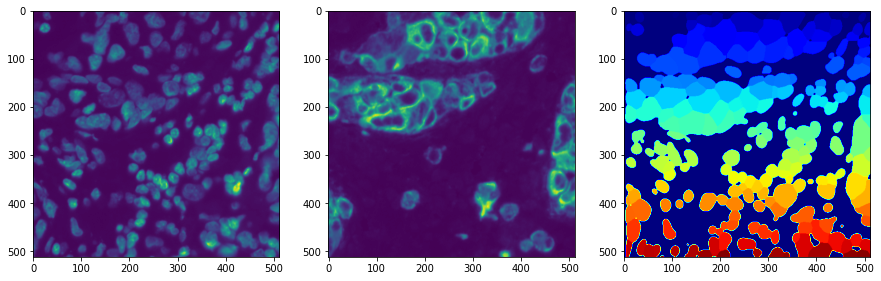

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(im[0, ..., 0])
ax[1].imshow(im[0, ..., 1])
ax[2].imshow(labeled_im[0, ..., 0], cmap = 'jet')
plt.show()

## Whole Cell Labeling (Prediction on Test Data)

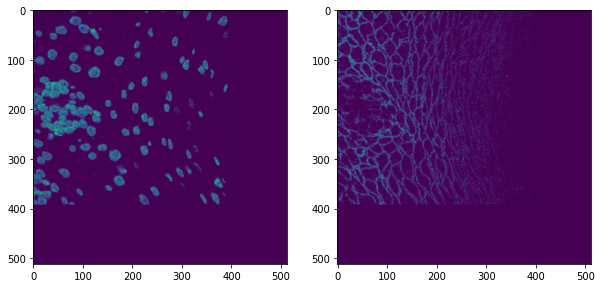

In [15]:
i = 0
test_im = X_test[i:(i+1)]
test_im.shape
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

#test_im[0,...,1]=test_im[0,...,0]
ax[0].imshow(test_im[0, ..., 0])
ax[1].imshow(test_im[0, ..., 1])
plt.show()


In [16]:
labeled_test_im = app.predict(new_test, image_mpp=0.5)

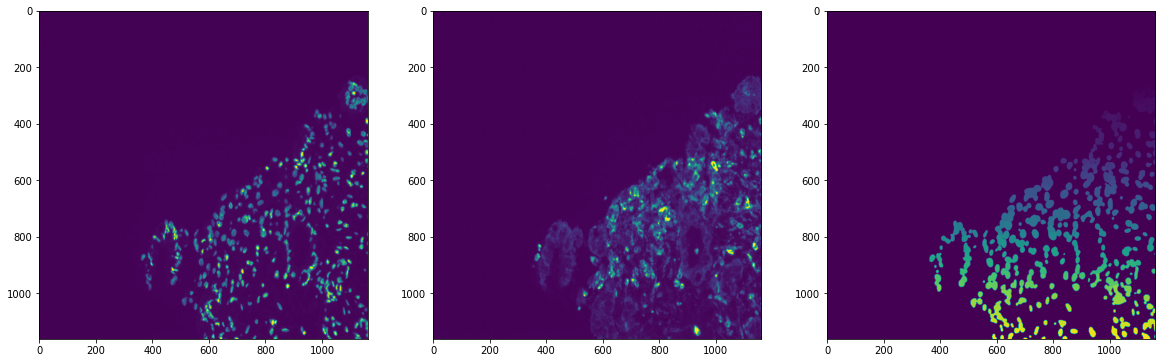

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

ax[0].imshow(new_test[0,...,0])

ax[1].imshow(new_test[0,...,1])

ax[2].imshow(labeled_test_im[0,...,0])

362

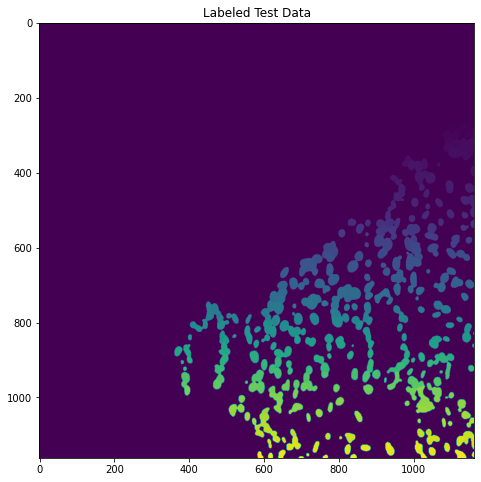

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(labeled_test_im[0,...,0])
plt.title("Labeled Test Data")

labeled_test_im[0,...,0].max()



#### Full Binarized Labeled Test Image

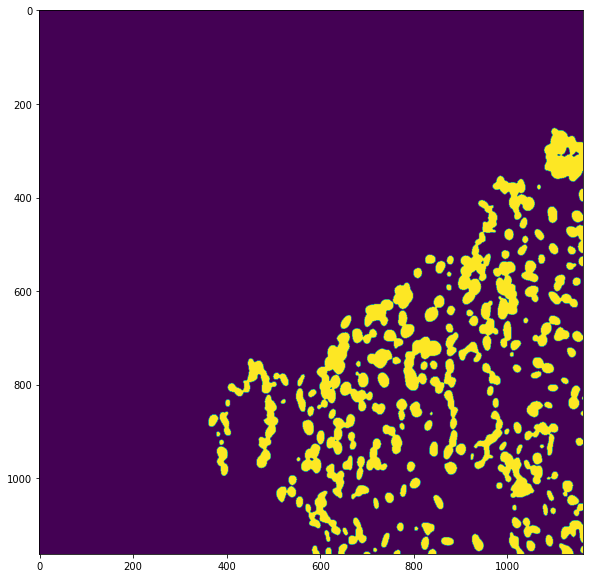

In [19]:
def to_binary(img, lower, upper):
    return (lower < img) & (img < upper)


binary = to_binary(labeled_test_im[0,...,0], 0.0001, 440)
plt.figure(figsize=(10,10))
plt.imshow(binary)

In [20]:
from deepcell import image_generators
from deepcell.utils import train_utils

transforms = ['centroid', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

batch_size = 1
min_objects = 1

# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)


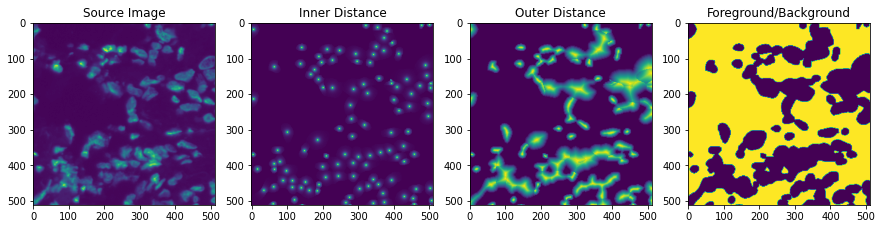

(512, 512)

In [21]:
from matplotlib import pyplot as plt

inputs, outputs = val_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()

inner_distance.shape
inner_distance[0,...,0].shape

Text(0.5, 1.0, 'Foreground/Background')

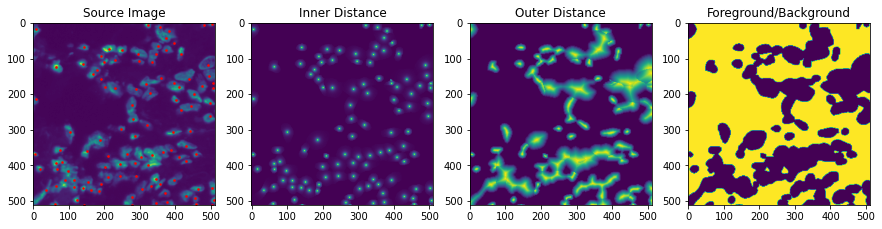

In [22]:
from skimage.feature import peak_local_max
from deepcell_toolbox.deep_watershed import deep_watershed

coords = peak_local_max(
    inner_distance[0,...,0],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')



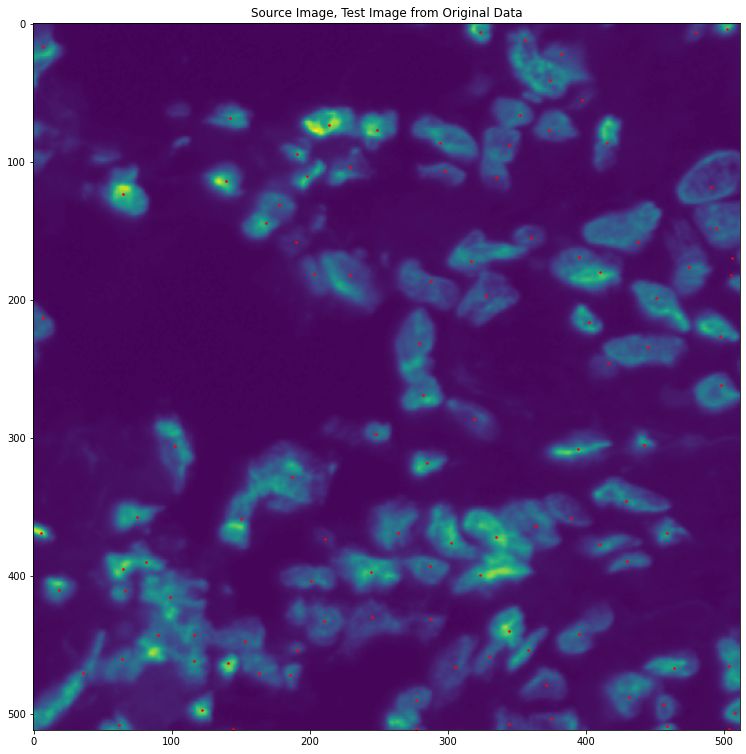

In [23]:
plt.figure(figsize=(13,13))
plt.imshow(img[..., 0])
plt.title('Source Image, Test Image from Original Data')
plt.scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

Text(0.5, 1.0, 'Foreground/Background')

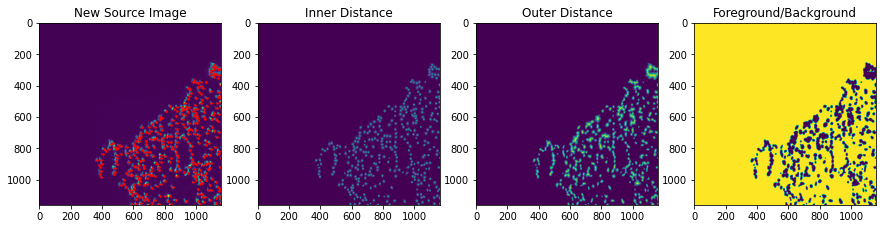

In [24]:
X_test_new = new_test
y_test_new = labeled_test_im


val_data_new = datagen_val.flow(
    {'X': X_test_new, 'y': y_test_new},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

inputs, outputs = val_data_new.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

coords = peak_local_max(
    inner_distance[0,...,0],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)


fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('New Source Image')
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')



357


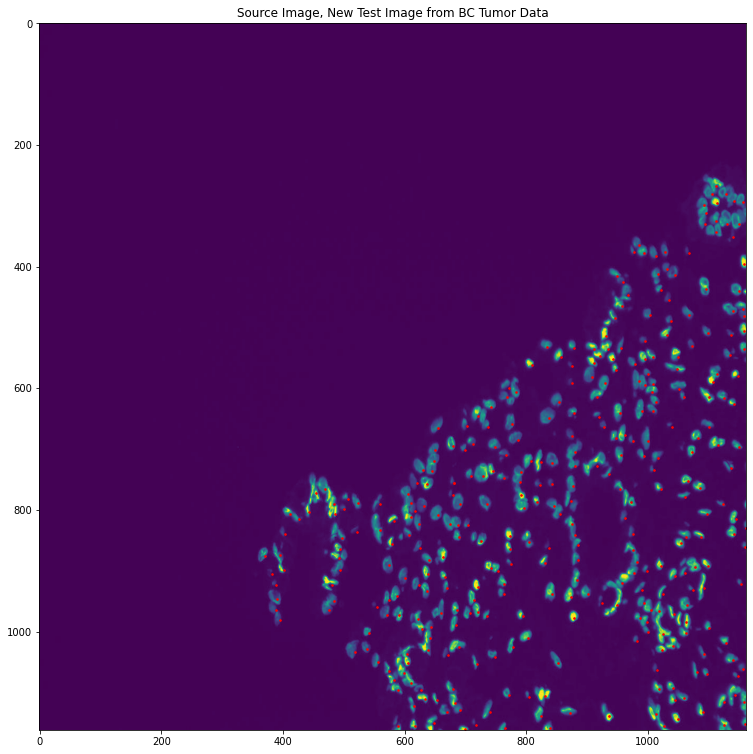

In [25]:
plt.figure(figsize=(13,13))
plt.imshow(img[..., 0])
plt.title('Source Image, New Test Image from BC Tumor Data')
plt.scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)
print(len(coords))

## Nuclear Cell Segmentation 

In addition to predicting whole-cell segmentation, this application can also be used for nuclear predictions

In [26]:
labeled_nuc_im = app.predict(new_test, image_mpp=0.5, compartment = 'nuclear')
labeled_nuc_im.shape

(1, 1162, 1162, 1)

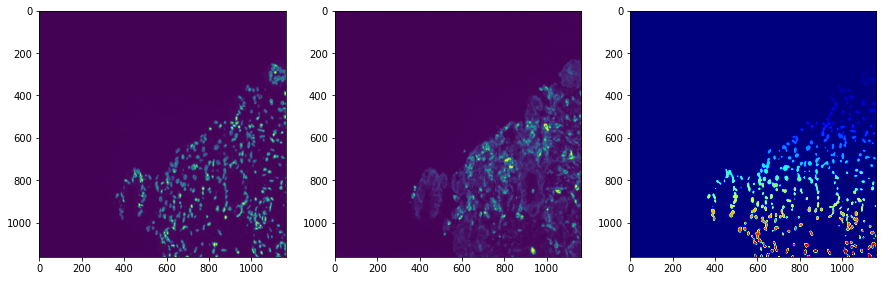

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(new_test[0, ..., 0])
ax[1].imshow(new_test[0, ..., 1])
ax[2].imshow(labeled_nuc_im[0, ..., 0], cmap = "jet")
plt.show()

0

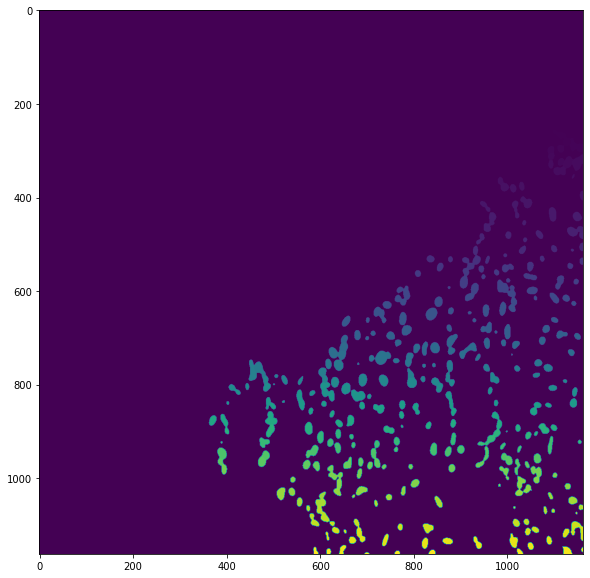

In [28]:
#from matplotlib.figure import figure
plt.figure(figsize = (10,10))
plt.imshow(labeled_nuc_im[0, ... , 0])


np.min(labeled_nuc_im[0, ... , 0])

To improve the centroid identification, the nuclear channel and labeled nuclear data is used here:

In [29]:
X_test_nuc = new_test
y_test_nuc = labeled_nuc_im
X_test_nuc = X_test_nuc[:,...,0]
X_test_nuc = X_test_nuc[:,...,np.newaxis]

Text(0.5, 1.0, 'Foreground/Background')

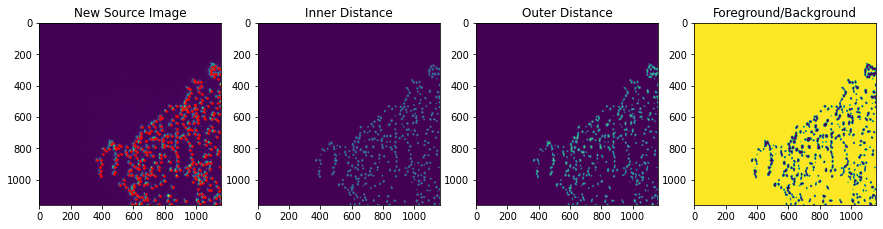

In [30]:
val_data_nuc = datagen_val.flow(
    {'X': X_test_nuc, 'y': y_test_nuc},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

inputs, outputs = val_data_nuc.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

coords = peak_local_max(
    inner_distance[0,...,0],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('New Source Image')
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 0])
axes[3].set_title('Foreground/Background')

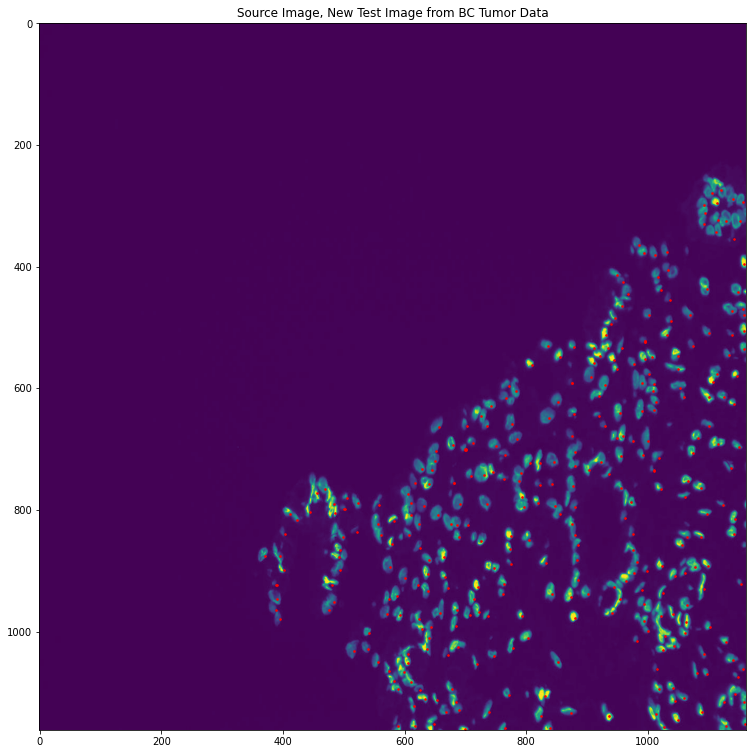

In [31]:
plt.figure(figsize=(13,13))
plt.imshow(img[..., 0])
plt.title('Source Image, New Test Image from BC Tumor Data')
plt.scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

# Unsqueeze test image/labeled image to original aspect ratio

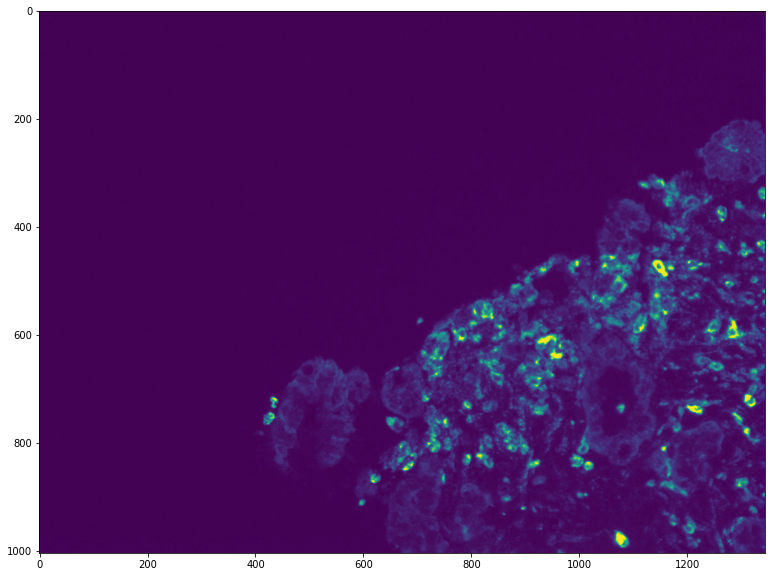

In [32]:
#Unsqueeze image to original size 
import cv2 
labeled_nuc_im[0, ..., 0]
new_test[0, ..., 0]

r_nuc_im = Image.fromarray(new_test[0, ..., 0])
r_labeled_nuc_im = Image.fromarray(labeled_nuc_im[0, ..., 0])
r_membrane_im = Image.fromarray(new_test[0, ..., 1])
r_labeled_memb_im = Image.fromarray(labeled_test_im[0,...,0])

r_nuc_im = r_nuc_im.resize((original_width, original_length))
r_labeled_nuc_im = r_labeled_nuc_im.resize((original_width, original_length)) #resize filter applied to obtain original aspect ratio
r_membrane_im = r_membrane_im.resize((original_width, original_length)) 
r_labeled_memb_im = r_labeled_memb_im.resize((original_width, original_length))

r_nuc_im = np.array(r_nuc_im)
r_labeled_nuc_im = np.array(r_labeled_nuc_im)
r_membrane_im = np.array(r_membrane_im)
r_labeled_memb_im = np.array(r_labeled_memb_im)

plt.figure(figsize=(13,13))
plt.imshow(r_membrane_im)


362

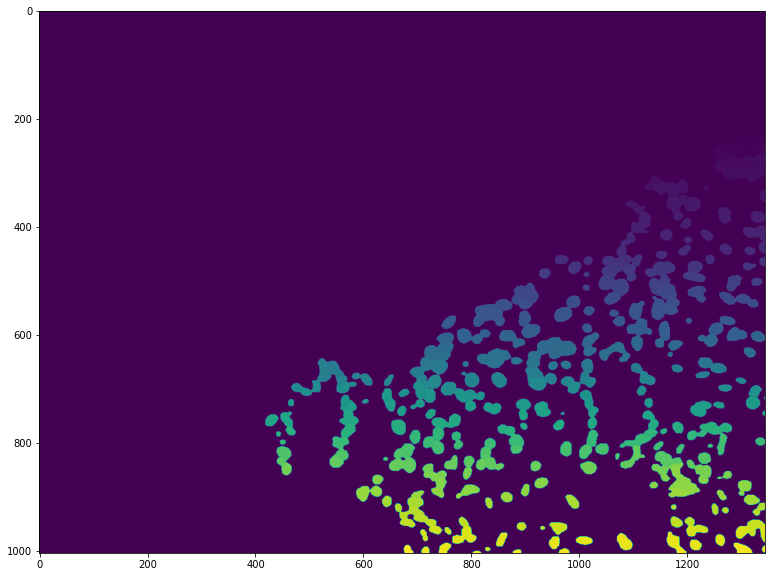

In [33]:
new_labeled_memb_im = cv2.resize(labeled_test_im[0,...,0], (original_width, original_length), interpolation = cv2.INTER_NEAREST)
new_labeled_memb_im

plt.figure(figsize=(13,13))
plt.imshow(new_labeled_memb_im)

np.min(new_labeled_memb_im)
np.max(new_labeled_memb_im)

In [34]:
#Re-transformed centroid points and plot

length_factor = sqrWidth/r_labeled_nuc_im.shape[1]
width_factor = sqrWidth/r_labeled_nuc_im.shape[0]

print(width_factor)
print(length_factor)


#multiply centroids x coords (width) by width_factor
#multiply centroids y coords (length) by width_factor


1.157370517928287
0.8645833333333334


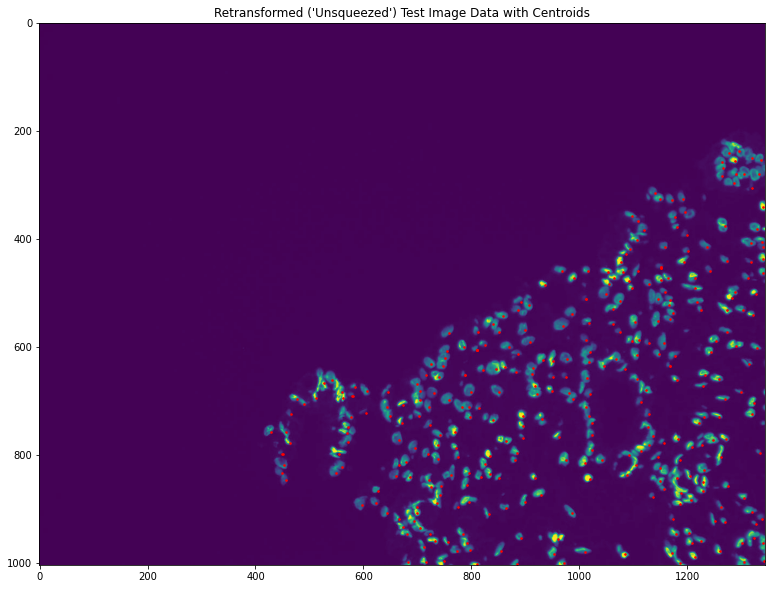

In [35]:
val_data_nuc = datagen_val.flow(
    {'X': X_test_nuc, 'y': y_test_nuc},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

inputs, outputs = val_data_nuc.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

coords = peak_local_max(
    inner_distance[0,...,0],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)


coords[...,1] = np.dot(coords[...,1], width_factor)
coords[...,0] = np.dot(coords[...,0], length_factor)

plt.figure(figsize=(13,13))
plt.imshow(r_nuc_im)
plt.title('Retransformed (\'Unsqueezed\') Test Image Data with Centroids')
plt.scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)


Cell Below Exports Centroid Information to Text File Called Test Data Centroids

In [36]:
#export the x and y coordinate into a text file by iterating through
#FOV number/index   
    
    
#def export_centroids(num_images):

#    file_object  = open("Test Data Centroids.txt", "w")
#    index = 0
    
#    file_object.write("In each field of view(FOV), objects coordinates are ordered from decreasing y coordinates")
#    file_object.write("(moving up along the image). If two objects have the same y coordinate, then ")
        
#    for i in range(0, num_images):
          
#        file_object.write("FOV #: " + str(index+1) + "\n")
#        file_object.write("# of Objects: " + str(len(coords)) + "\n\n")
#        
#        file_object.write("[X1 X2 ....]:\n\n")
#        file_object.write(str(coords[...,1])+"\n\n")
        
#        file_object.write("[Y1 Y2 ....]:\n\n")
#        file_object.write(str(coords[...,0])+"\n")
#        file_object.write("\n")
        
#        index+=1
#    file_object.close() 
    
#export_centroids(1)
len(coords)

351

# Intensity Information

- Output Intensity List on Segmentend Labeled Output (each label is a separate intensity)
    - this seperate overlapping objects 
    - this includes contours of detected cell objects only
    - Maintain Intensities (do not normalize)
- Highlight objects at a specific intensity
- Use True/False locations in highlighted mask to compute average intensity, size, and min/max intensities, and use contour to compute centroid


In [126]:
#functions for intensity extraction

def border_object(x_coord, y_coord, FOV_max_x, FOV_max_y):
    """Return true if object contains a border pixel
    
    Keyword arguments:
    x_coord -- flattened list of x coordinates of contour
    y_coord -- flattened list of y coordinates of contour
    FOV_max_x -- maximum value of x coordinate of FOV in which object is located in
    FOV_max_y -- maximum value of y coordinate of FOV in which object is located in
    
    """
    if FOV_max_x in x_coord:
        return True
    if FOV_max_y in y_coord:
        return True
    if 0 in x_coord or 0 in y_coord:
        return True
    return False   


def intensity_list_gen(FOV_labeled):
    
    
    """Return list of all label intensities except for 0 intensity
    
    Keyword arguments:
    FOV_labeled -- FOV with labels of cell objects

    """
    rang = list(FOV_labeled.flat)
    res = []
    for i in rang:
        if i not in res:
            res.append(i)
    res.pop(0) #does not include 0 intensity
    return res

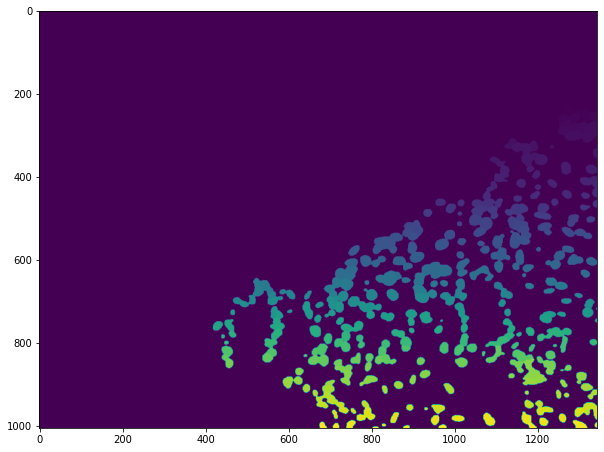

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(new_labeled_memb_im)

### Solving overlap Issue

- sorted labeled intensities (contour levels) are used as thresholds


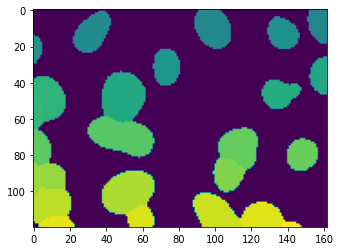

In [55]:
#Arbitrarily selected regions
l_region = labeled_test_im[0,500:620,1000:1162,0]
orig_region = new_test[0,500:620, 1000:1162,1]

res = intensity_list_gen(l_region)
plt.imshow(l_region)

In [56]:
#ctr_region = plt.contour(padded_array_r, 65, colors = 'red')
#plt.gca().invert_yaxis()
#plt.imshow(padded_array_r)
#print(len(ctr_region.collections[0].get_paths()))
#print(res[8])
#a = labeled_test_im[0, ..., 0]
#rang = list(a.flat)
#res = []
#for i in rang:
#    if i not in res:
#        res.append(i)
#a = a == res[2]



Metrics: 

Total Area Average Intensity: 184.03703703703704
Total Area Max Intensity: 255.0
Total Area Min Intensity: 68.0


Contour Average Intensity: 116.48484848484848
Contour Area Max Intensity: 255.0
Contour Area Min Intensity: 56.0


X Centroid Loc: 1.6851851851851851
Y Centroid Loc: 54.19444444444444

Border Object?:  True

Note: The labeled objects are not accurate here since the model was not predicted on this FOV. In addition, pre-trained weights were used.


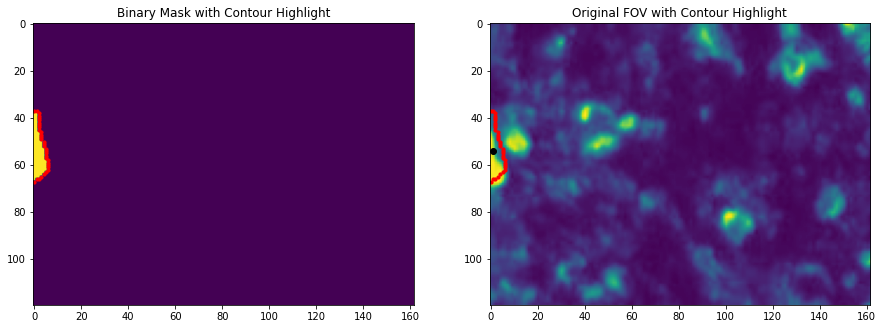

In [57]:
from skimage import measure
i = 9 #object number
temp_highlight = l_region == res[i]

#ctr_region = plt.contour(temp_highlight, res[i], colors = 'red')
#plt.gca().invert_yaxis()
#vert_ctr = ctr_region.collections[0].get_paths()[0]
#v = vert_ctr.vertices
#v = np.transpose(v)
#centroid = [sum(v[0][:]) // v.shape[1], sum(v[1][:]) // v.shape[1]]

contours = measure.find_contours(temp_highlight, 0)
contours = contours[:][:][0]

ii = np.where(temp_highlight == True)

#total area intensity information for each object
length_coord = len(ii[0])
intensities = np.zeros(length_coord)
x = np.zeros(length_coord)
y = np.zeros(length_coord)

for j in range(length_coord):
    x_temp = ii[1][j]
    y_temp = ii[0][j]
    intensities[j] = orig_region[y_temp][x_temp]
    x[j] = x_temp
    y[j] = y_temp

#contour intensity information for each object 
c_intensities = np.zeros(len(contours[:,0]))
c_x = np.zeros(len(contours[:,0]))
c_y = np.zeros(len(contours[:,0]))

for k in range(len(contours[:,0])):
    c_x = int(contours[:,1][k])
    c_y = int(contours[:,0][k])
    c_intensities[k] = orig_region[c_y][c_x]
    
X =  np.mean(x)
Y = np.mean(y)

print("\nMetrics: \n")
print("Total Area Average Intensity:", np.mean(intensities))
print("Total Area Max Intensity:", max(intensities))
print("Total Area Min Intensity:", min(intensities))
print("\n")
print("Contour Average Intensity:", np.mean(c_intensities))
print("Contour Area Max Intensity:", max(c_intensities))
print("Contour Area Min Intensity:", min(c_intensities))
print("\n")
print("X Centroid Loc:", X)
print("Y Centroid Loc:", Y)
print("\nBorder Object?: ", border_object(list(contours[:,1]), list(contours[:,0]), orig_region.shape[1]-1, orig_region.shape[0]-1)) 

fig, ax = plt.subplots(1, 2, figsize=(15, 15))

ax[0].imshow(temp_highlight)
ax[0].scatter(contours[:,1], contours[:,0], s = 10, c = 'r')
ax[0].set_title("Binary Mask with Contour Highlight")
ax[1].imshow(orig_region) 
ax[1].scatter(int(X), int(Y), color = 'black')
ax[1].scatter(contours[:,1], contours[:,0], s= 10, c = 'r')
ax[1].set_title("Original FOV with Contour Highlight")
print("\nNote: The labeled objects are not accurate here since the model was not predicted on this FOV. In addition, pre-trained weights were used.")

### Testing on Full FOV

In [67]:
l_region = new_labeled_memb_im
orig_region = r_membrane_im
res = intensity_list_gen(l_region)


Metrics: 

Total Area Average Intensity: 17.308
Total Area Max Intensity: 41.0
Total Area Min Intensity: 2.0


Contour Average Intensity: 9.545454545454545
Contour Area Max Intensity: 24.0
Contour Area Min Intensity: 2.0


X Centroid Loc: 578.496
Y Centroid Loc: 731.272

Border Object?:  False


Text(0.5, 1.0, 'Zoomed in original FOV (Note: includes extra pixels not in computation)')

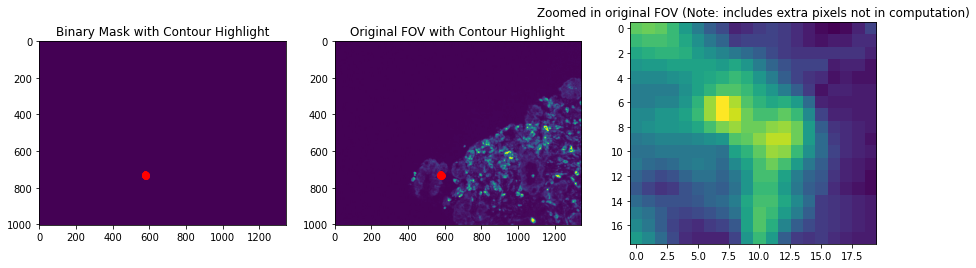

In [71]:
i = 200 #object number
temp_highlight = l_region == res[i]

contours = measure.find_contours(temp_highlight, 0)
contours = contours[:][:][0]

ii = np.where(temp_highlight == True)

#total area intensity information for each object
length_coord = len(ii[0])
intensities = np.zeros(length_coord)
x = np.zeros(length_coord)
y = np.zeros(length_coord)

for j in range(length_coord):
    x_temp = ii[1][j]
    y_temp = ii[0][j]
    intensities[j] = orig_region[y_temp][x_temp]
    x[j] = x_temp
    y[j] = y_temp

#contour intensity information for each object 
c_intensities = np.zeros(len(contours[:,0]))
c_x = np.zeros(len(contours[:,0]))
c_y = np.zeros(len(contours[:,0]))

for k in range(len(contours[:,0])):
    c_x = int(contours[:,1][k])
    c_y = int(contours[:,0][k])
    c_intensities[k] = orig_region[c_y][c_x]
    
X =  np.mean(x)
Y = np.mean(y)

print("\nMetrics: \n")
print("Total Area Average Intensity:", np.mean(intensities))
print("Total Area Max Intensity:", max(intensities))
print("Total Area Min Intensity:", min(intensities))
print("\n")
print("Contour Average Intensity:", np.mean(c_intensities))
print("Contour Area Max Intensity:", max(c_intensities))
print("Contour Area Min Intensity:", min(c_intensities))
print("\n")
print("X Centroid Loc:", X)
print("Y Centroid Loc:", Y)
print("\nBorder Object?: ", border_object(list(contours[:,1]), list(contours[:,0]), orig_region.shape[1]-1, orig_region.shape[0]-1)) 

fig, ax = plt.subplots(1, 3, figsize=(15, 15))

ax[0].imshow(temp_highlight)
ax[0].scatter(contours[:,1], contours[:,0], s = 10, c = 'r')
ax[0].set_title("Binary Mask with Contour Highlight")
ax[1].imshow(orig_region) 
ax[1].scatter(int(X), int(Y), color = 'black')
ax[1].scatter(contours[:,1], contours[:,0], s= 10, c = 'r')
ax[1].set_title("Original FOV with Contour Highlight")



width = max(contours[:,0])-min(contours[:,0])
height = max(contours[:,1])-min(contours[:,1])
temp_image = Image.fromarray(r_membrane_im)
left = (X - (width//2))
right = (X + (width//2))
bottom = (Y + (height//2))
top = (Y - (height//2))
crop_temp_image = temp_image.crop((left, top, right, bottom))
new_temp_image = np.array(crop_temp_image)


ax[2].imshow(new_temp_image)
ax[2].set_title("Zoomed in original FOV (Note: includes extra pixels not in computation)")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


<Figure size 432x288 with 0 Axes>

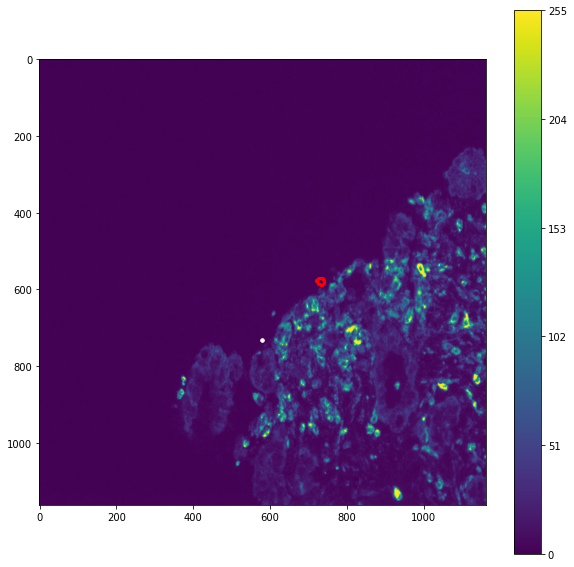

255
0


In [73]:
plt.figure()
plt.figure(figsize=(10,10))
plt.imshow(new_test[0,...,1])
plt.scatter((X), (Y),
                color='w', marker='.', s=50)
plt.scatter(contours[:,0], (contours[:,1]),
                color='r', marker='.', s=10)
cb = plt.colorbar()
cb.ax.set_yticklabels(['0', '51', '102', '153', '204', '255'])
plt.show()

print(np.max(new_test[0,...,1]))
print(np.min(new_test[0,...,1]))

### All Contours in FOV

Retraining the Segmentation Model using a Training Set instead of the pretrained weights will definitely improve issue of
missed cell objects


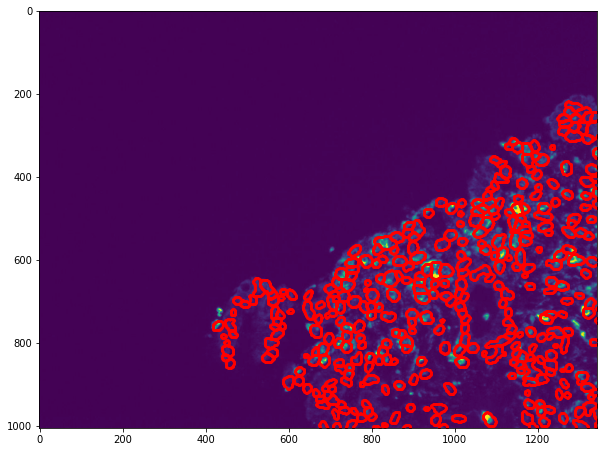

In [94]:
i = 0;
plt.figure(figsize = (10,16))
plt.imshow(orig_region)
for i in range(len(res)):
    temp_highlight = l_region == res[i]
    contours = measure.find_contours(temp_highlight, 0)
    contours = contours[:][:][0]
    plt.scatter(contours[:,1], contours[:,0], s = 2, c = 'r')
    
print("Retraining the Segmentation Model using a Training Set instead of the pretrained weights will definitely improve issue of")
print("missed cell objects")
      

### Computing Dataframe with:
- Cell Index
- Total Area Mean Intensity
- Total Area Max Intensity
- Total Area Min Intensity
- Contour Mean Intensity
- Contour Max Intensity
- Contour Min Intensity
- Border Object (Yes/No)
- Cell Object Size (Total Pixels)
- Centroid X Coord 
- Centroid Y Coord


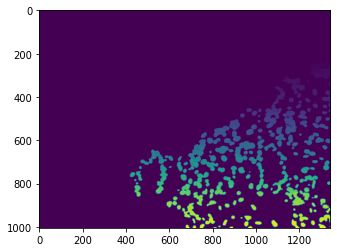

In [104]:
l_region = new_labeled_memb_im
orig_region = r_membrane_im

res = intensity_list_gen(l_region)
plt.imshow(l_region)
number_cells = len(res)

array_df = np.zeros((number_cells, 11)) #create dataframe

for i in range(number_cells):

    array_df[i][0] = i + 1
    temp_highlight = l_region == res[i] #developed mask 
    
    ii = np.where(temp_highlight == True) #temporarily store locations 
    length_coord = len(ii[0])
    intensities = np.zeros(length_coord)
    x = np.zeros(length_coord)
    y = np.zeros(length_coord)
    
    contours = measure.find_contours(temp_highlight, 0) #compute contour
    contours = contours[:][:][0]
    
    c_intensities = np.zeros(len(contours[:,0])) #contour pixel intensity values
    c_x = np.zeros(len(contours[:,0])) #x coordinates
    c_y = np.zeros(len(contours[:,0])) #y coordinates

    for k in range(len(contours[:,0])):
        c_x = int(contours[:,1][k])
        c_y = int(contours[:,0][k])
        c_intensities[k] = orig_region[c_y][c_x]
    
    for j in range(length_coord): #extract from original image/compute average intensities/centroid based off this
        y_temp = ii[0][j]
        y[j] = y_temp
        x_temp = ii[1][j]
        x[j] = x_temp
        intensities[j] = orig_region[y_temp][x_temp]
        
    #store in data frame
    array_df[i][1] = np.mean(intensities) #total area mean intensity
    array_df[i][2] = np.max(intensities) #total area max intensity
    array_df[i][3] = np.min(intensities) #total area min intensity
    array_df[i][4] = np.mean(c_intensities) #contour mean intensity
    array_df[i][5] = np.max(c_intensities) #contour max intensity
    array_df[i][6] = np.min(c_intensities) #contour min intensity
    array_df[i][7] = border_object(list(contours[:,1]), list(contours[:,0]), orig_region.shape[1]-1, orig_region.shape[0]-1)
    #border object
    array_df[i][8] = len(intensities) #total pixel area (total pixels)
    array_df[i][9] = np.mean(x) #Centroid X Location
    array_df[i][10] = np.mean(y) #Centroid Y Location

In [105]:
#convert array to data frame
import pandas as pd  
metrics = pd.DataFrame(array_df)
metrics.style.set_caption("PD-L1 Test")
metrics.columns = ['Cell Index', 'Total Area Mean Intensity', 'Total Area Max Intensity', 'Total Area Min Intensity', 'Contour Average Intensity', 
                'Contour Max Intensity', 'Contour Min Intensity', 'Border Object', 'Pixel Area', 'X Centroid Coord', 'Y Centroid Coord']

metrics.head()

Cell Index  Total Area Mean Intensity  Total Area Max Intensity  \
0         1.0                  31.217143                      70.0   
1         2.0                  53.322430                     139.0   
2         3.0                  23.802661                      40.0   
3         4.0                  29.822335                     106.0   
4         5.0                  30.807947                      46.0   

   Total Area Min Intensity  Contour Average Intensity  Contour Max Intensity  \
0                      14.0                  28.936842                   68.0   
1                      25.0                  48.283784                  103.0   
2                       9.0                  25.886364                   40.0   
3                      14.0                  30.160000                   79.0   
4                      15.0                  33.520833                   49.0   

   Contour Min Intensity  Border Object  Pixel Area  X Centroid Coord  \
0                   11.0            0.0       525.0       1285.895238   
1                   24.0            0.0       428.0       1275.997664   
2                   12.0            0.0       451.0       1307.898004   
3                   17.0            0.0       394.0       1319.728426   
4                   21.0            1.0       302.0       1336.208609   

   Y Centroid Coord  
0        228.704762  
1        242.084112  
2        242.288248  
3        254.228426  
4        254.394040

In [106]:
metrics.to_csv('FOV_Multiplex-Application-Edited.csv') #output Final Data